# TP - Computação Natural
#### "Predict whether a mammogram mass is benign or malignant"

1. BI-RADS assessment: 1 to 5 (ordinal)  
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal)

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

Using TensorFlow backend.


## Get the Data

In [3]:
data = pd.read_csv('mammographic_masses.data.txt', names=['BI_RADS','Age','Shape','Margin','Density','Severity'])

Convert missing data (indicated by a ?) into NaN and add the appropriate column names (BI_RADS, age, shape, margin, density, and severity)

In [4]:
data = data.replace('?',np.nan)
data

,BI_RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


**Drop BI_RADS column because it has no influence on the severity forecast**

In [5]:
data = data.drop(columns=['BI_RADS', 'Density'])

**Convert datatype 'object' to 'float64'**  

In [6]:
data = data.astype(float)

In [7]:
data = data.dropna()
data.index = np.arange(1, len(data) + 1)
data

,Age,Shape,Margin,Severity
1,67.0,3.0,5.0,1.0
2,43.0,1.0,1.0,1.0
3,58.0,4.0,5.0,1.0
4,28.0,1.0,1.0,0.0
5,74.0,1.0,5.0,1.0
...,...,...,...,...
883,47.0,2.0,1.0,0.0
884,56.0,4.0,5.0,1.0
885,64.0,4.0,5.0,0.0
886,66.0,4.0,5.0,1.0


### Detect outliers using mathematical function Z-Score

In [8]:
z = np.abs(stats.zscore(data))
threshold = 2
print(np.where(z > threshold))
# The first array contains the list of row numbers and second array respective column numbers

(array([ 37,  41,  52,  61, 100, 109, 134, 136, 140, 141, 153, 165, 207,
       285, 293, 300, 322, 377, 411, 415, 455, 462, 465, 468, 485, 489,
       497, 518, 536, 549, 555, 615, 628, 645, 659, 666, 676, 677, 711,
       727, 755, 758, 775, 776, 796, 797, 853, 855]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]))


### Detect outliers using IQR Score
Similar to Z-Score

In [9]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
iqr = Q3 - Q1
print(iqr)

Age         21.0
Shape        2.0
Margin       3.0
Severity     1.0
dtype: float64


## Data Preparation

### Remove Outliers using Z-Score

##### + explanations: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

In [10]:
# Como z-score estava
data = data[(np.abs(stats.zscore(data)) < 2).all(axis=1)]
data.index = np.arange(1, len(data) + 1)
data

,Age,Shape,Margin,Severity
1,67.0,3.0,5.0,1.0
2,43.0,1.0,1.0,1.0
3,58.0,4.0,5.0,1.0
4,28.0,1.0,1.0,0.0
5,74.0,1.0,5.0,1.0
...,...,...,...,...
835,47.0,2.0,1.0,0.0
836,56.0,4.0,5.0,1.0
837,64.0,4.0,5.0,0.0
838,66.0,4.0,5.0,1.0


#### Discretize Age feature

In [11]:
age = data.loc[:,'Age']
data['Age'] = pd.cut(x=age, bins=[0,40, 55,60, 100], labels=["<40","40-55","55-60",">60"])
data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Age,Shape,Margin,Severity
1,>60,3.0,5.0,1.0
2,40-55,1.0,1.0,1.0
3,55-60,4.0,5.0,1.0
4,<40,1.0,1.0,0.0
5,>60,1.0,5.0,1.0
...,...,...,...,...
835,40-55,2.0,1.0,0.0
836,55-60,4.0,5.0,1.0
837,>60,4.0,5.0,0.0
838,>60,4.0,5.0,1.0


count     839
unique      4
top       >60
freq      325
Name: Age, dtype: object
mode:  0    >60
Name: Age, dtype: category
Categories (4, object): [<40 < 40-55 < 55-60 < >60]
>60      325
40-55    278
55-60    125
<40      111
Name: Age, dtype: int64


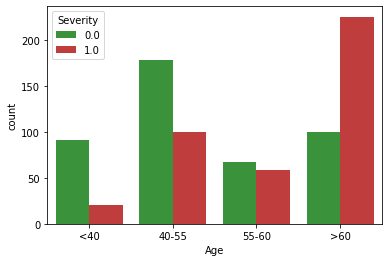

In [12]:
c_palette = ['tab:green','tab:red']

def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()
    
categorical_summarized(data, x = 'Age', hue='Severity', palette=c_palette)

**One Hot Encode all features**

In [13]:
one_hot = pd.get_dummies(data['Age'])
data = data.drop('Age',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Age_1", 2.0: "Age_2", 3.0: "Age_3", 4.0: "Age_4"})

one_hot = pd.get_dummies(data['Shape'])
data = data.drop('Shape',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Shape_1", 2.0: "Shape_2", 3.0: "Shape_3", 4.0: "Shape_4"})

one_hot = pd.get_dummies(data['Margin'])
data = data.drop('Margin',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Margin_1", 2.0: "Margin_2", 3.0: "Margin_3", 4.0: "Margin_4", 5.0: "Margin_5"})


data

,Severity,<40,40-55,55-60,>60,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
1,1.0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,1.0,0,1,0,0,1,0,0,0,1,0,0,0,0
3,1.0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0
5,1.0,0,0,0,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0
836,1.0,0,0,1,0,0,0,0,1,0,0,0,0,1
837,0.0,0,0,0,1,0,0,0,1,0,0,0,0,1
838,1.0,0,0,0,1,0,0,0,1,0,0,0,0,1


## Train Test Split

**Create training and testing sets of the data**

In [14]:
X = data.drop('Severity',axis=1).to_numpy()
y = data['Severity'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [15]:
np.info(X_train)
print("---")
np.info(X_test)
print("---")
np.info(y_train)
print("---")
np.info(y_test)

class:  ndarray
shape:  (587, 13)
strides:  (13, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f9cdef74000
byteorder:  little
byteswap:  False
type: uint8
---
class:  ndarray
shape:  (252, 13)
strides:  (13, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f9cdd966200
byteorder:  little
byteswap:  False
type: uint8
---
class:  ndarray
shape:  (587,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7f9ce123c600
byteorder:  little
byteswap:  False
type: float64
---
class:  ndarray
shape:  (252,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7f9ce1224c00
byteorder:  little
byteswap:  False
type: float64


## Neural Networks & Genetic Algorithms

In [16]:
# Função que contrói o modelo ANN
def buildModel(hidden_layers, nodes_per_layer, activation_fn, optimizer, lr, loss_fn, metrics, inputs=13):
    model = Sequential()
    #add input layer
    model.add(Dense(inputs, activation="sigmoid", input_shape=(inputs,)))

    #add hidden layers    
    for i in range(int(hidden_layers)):
        model.add(Dense(int(nodes_per_layer), activation=activation_fn))

    #add output layer
    model.add(Dense(1,activation="sigmoid"))
    
    if(optimizer=='SGD'): optimizer = SGD(learning_rate=lr)
    elif(optimizer=='RMSprop'): optimizer = RMSprop(learning_rate=lr)
    elif(optimizer=='Adam'): optimizer = Adam(learning_rate=lr)

    #compile model
    model.compile(optimizer, loss=loss_fn, metrics=metrics)

    return model

# Função que realiza uma previsão para o modelo
def evaluatePredictions(model, input_attributes, labels):
    predicted = model.predict(input_attributes)
    

    LP = roundPredictions(predicted)
    
    accuracy = accuracy_score(labels, LP)
    recall = recall_score(labels, LP, average=None)
    precision = precision_score(labels, LP, average=None)
    
    return accuracy, recall[0], precision[0], recall[1], precision[1]

    
#Função que cria a população inicial
#parameters=[hidden_layers,nodes_per_layer,activation_fn,learning_rate,optimizer,loss_fn]
def create_new_population():
    
    population=[]
    
    for i in range(10):
        cromo=[]
        cromo.append(np.random.randint(low=1, high=17))
        cromo.append(np.random.choice([1, 2, 4, 8, 16, 32, 64, 128, 256]))
        cromo.append(np.random.randint(low=0, high=6))
        cromo.append(np.random.choice([0.001, 0.01, 0.1, 1]))
        cromo.append(np.random.randint(low=0, high=3))
        cromo.append(np.random.randint(low=0, high=3))
        population.append(cromo)
        
    return np.array(population)

#Função genérica que atualiza os argumentos do classifier
#parameters=[hidden_layers,nodes_per_layer,activation_fn,learning_rate,optimizer,loss_fn]
def update_model_parameters(parameters):
    
    if((parameters[2]) == 0): a_f = 'relu'
    if((parameters[2]) == 1): a_f = 'selu'
    if((parameters[2]) == 2): a_f = 'sigmoid'
    if((parameters[2]) == 3): a_f = 'tanh'
    if((parameters[2]) == 4): a_f = 'linear'
    if((parameters[2]) == 5): a_f = 'softmax'
        
        
    if((parameters[4]) == 0): opt_f = 'SGD'
    if((parameters[4]) == 1): opt_f = 'RMSprop'
    if((parameters[4]) == 2): opt_f = 'Adam'
        
    if((parameters[5]) == 0): loss = 'binary_crossentropy'
    if((parameters[5]) == 1): loss = 'hinge'
    if((parameters[5]) == 2): loss = 'squared_hinge'
        
    model = buildModel(parameters[0], parameters[1], a_f, opt_f, parameters[3], loss, metrics=['accuracy'])

    return model

def select_mating_pool(pop, fitness, parents_fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    parents_fitness = []
    for parent_num in range(num_parents):
        #save fitness values of best parents
        parents_fitness.append(np.max(fitness))
        #save best parents
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
        
    return parents, parents_fitness

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        
        # Select which gene to mutate
        select_gene = np.random.randint(low=0, high=6)
 
        if(select_gene == 0):
            #num_hidden_layers mutation
            random_value = np.random.randint(low=1, high=17)
            offspring_crossover[idx,0] = random_value
        if(select_gene == 1):
            #num_nodes_per_layer mutation
            random_value = np.random.choice([4, 8, 16, 32, 64, 128, 256])
            offspring_crossover[idx,1] = random_value
        if(select_gene == 2):
            #activation function mutation
            random_value = np.random.randint(low=0, high=6)
            offspring_crossover[idx,2] = random_value
        if(select_gene == 3):
            #learning rate mutation
            random_value = np.random.choice([0.001, 0.01, 0.1, 1])
            offspring_crossover[idx,3] = random_value
        if(select_gene == 4):
            #optimizer mutation
            random_value = np.random.randint(low=0, high=3)
            offspring_crossover[idx,4] = random_value
        if(select_gene == 5):
            #loss function mutation
            random_value = np.random.randint(low=0, high=3)
            offspring_crossover[idx,5] = random_value
            
    return offspring_crossover

def printChromo(chromo, tab=False):
    
    identation = "\t" if tab else ""
    
    if((chromo[2]) == 0): a_f = 'relu'
    if((chromo[2]) == 1): a_f = 'selu'
    if((chromo[2]) == 2): a_f = 'sigmoid'
    if((chromo[2]) == 3): a_f = 'tanh'
    if((chromo[2]) == 4): a_f = 'linear'
    if((chromo[2]) == 5): a_f = 'softmax'
        
        
    if((chromo[4]) == 0): opt_f = 'SGD'
    if((chromo[4]) == 1): opt_f = 'RMSprop'
    if((chromo[4]) == 2): opt_f = 'Adam'
        
    if((chromo[5]) == 0): loss = 'binary_crossentropy'
    if((chromo[5]) == 1): loss = 'hinge'
    if((chromo[5]) == 2): loss = 'squared_hinge'
        
    print(identation + "Layers: {} |".format(int(chromo[0])),"Nodes: {} |".format(int(chromo[1])),"Act_F: {} |".format(a_f),"Opti: {} |".format(opt_f), "LR: {} |".format(chromo[3]),"Loss: {}".format(loss))
    
def printChromos(chromos, tab=False):
    for chromo in chromos:
        printChromo(chromo, tab)
    
def roundPredictions(predicted):
    # arredondar para 0 ou 1 pois pretende-se um output binário
    LP = []
    f = lambda x: int(round(x))
    vfunc = np.vectorize(f)
    
    for prev in predicted:
        prev = vfunc(prev)
        LP.append(prev)
    
    return LP

**K-Fold Cross Validation**

In [17]:
from sklearn.model_selection import KFold

num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

**Keras ANN built from specific parameters (one specific chromosome)**

In [18]:
def evaluateChromosome(chromosome):
    scores=[]
    recalls_0=[]
    precisions_0=[]
    recalls_1=[]
    precisions_1=[]
    
    model = update_model_parameters(chromosome)
    
    fold_no=1
    
    for train, test in kfold.split(X_train, y_train):

        history = model.fit(X_train[train], y_train[train],
              epochs=30,
              batch_size=64,
              verbose=0)

        score = model.evaluate(X_train[test], y_train[test], batch_size=64, verbose=0)      
        accuracy, recall_0, precision_0, recall_1, precision_1 = evaluatePredictions(model, X_train[test], y_train[test])

        #Adding all metrics to arrays
        scores.append(score[1])
        recalls_0.append(recall_0)
        precisions_0.append(precision_0)
        recalls_1.append(recall_1)
        precisions_1.append(precision_1)
    
        fold_no+=1
    
    score = sum(scores)/len(scores)
    recall_0 = sum(recalls_0)/len(recalls_0)
    precision_0 = sum(precisions_0)/len(precisions_0)
    recall_1 = sum(recalls_1)/len(recalls_1)
    precision_1 = sum(precisions_1)/len(precisions_1)

    return score, recall_0, precision_0, recall_1, precision_1

In [20]:
import time
start_time = time.time()

population = create_new_population()
print("Initial population:")
printChromos(population, True)
num_parents_mating = 5
num_generations = 10
# number of genes for each chromosome
num_genes = 6
# number of chromosomes for each population
num_chromosomes = 10 

pop_size=(num_chromosomes,num_genes)

# fitness values for each chromosome for the current generation
fitness_values = []
# fitness vaalues for each chromosome of the last generation
last_fitness_values = []

gen = 0
cromo = 0

parents=[]
# Parents fitness so we do not repeat calculations on parents
parents_fitness = []

performances=[]
hiperparameters=[]


for generation in range(num_generations):
    gen+=1
    cromo = 0
    best_perf_per_gen = -1
    
    for chromosome in population:
        known=False
        cromo+=1
        score=-1
        parentNumber=0
        
        # If it's a known chromosome we dont need to train the ANN again
        # Skips the first generation because we didnt select the parents yet
        for savedCromo in parents:
            parentNumber+=1
            if (np.array_equal(chromosome,savedCromo)):
                score = parents_fitness[parentNumber-1]
                known = True
        
        # If it's a new chromosome we need to train the ANN in order to get the accuracy
        if (score < 0):
            accuracy, recall_0, precision_0, recall_1, precision_1 = evaluateChromosome(chromosome)
            score = 0.5 * accuracy + 0.175 * recall_1 + 0.15 * precision_0 + 0.1 * recall_0 + 0.075 * precision_1
            
        if(not known):
            print("Generation-{}".format(gen),"Chromosome-{}:".format(cromo))
            printChromo(chromosome, True)
            print("\tScore {:.2f}".format(score)," || Acc: {:.2f}".format(accuracy),"|R0: {:.2f} ".format(recall_0),"|P0: {:.2f} ".format(precision_0), "|R1: {:.2f} ".format(recall_1),"|P1: {:.2f} ".format(precision_1))
        else:
            print("Generation-{}".format(gen),"Chromosome-{}".format(cromo),"scored {:.2f}".format(score), " (Chromosome already knowned)")

        
        # Keep the scores in fitness_values
        fitness_values.append(score)
        
        # Getting the best hyperparameters per generation to check the evolution at the end
        if(best_perf_per_gen < score):
            best_perf_per_gen = score
            best_cromo_per_gen = chromosome
                   
    performances.append(best_perf_per_gen)
    hiperparameters.append(best_cromo_per_gen)
   
    #print(performances,"Best accuracies of each generation")
    #print(hiperparameters,"Best of each generation")
    
    # We store last generation in other array because fitness_values is changed by the select_mating_pool
    if(gen == num_generations):
        for i in fitness_values:
            last_fitness_values.append(i)
        print(last_fitness_values,"Last Fitness Values")
    
    parents,parents_fitness = select_mating_pool(population,fitness_values,parents_fitness,num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                        offspring_size=(pop_size[0]-parents.shape[0], num_genes))

    # Adding some variations to the offspring using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation
    
    # Reset fitness_values
    fitness_values=[]

end_time = time.time()
# Getting the best solution
best_solution = population[last_fitness_values.index(np.max(last_fitness_values))]
print("The best hyperparameters obtained are:")
printChromo(best_solution, True)
print("with a score of",np.max(last_fitness_values))
print("--- GA Computacional time: %s minutes ---" % ((time.time() - start_time)*60))


Initial population:
	Layers: 9 | Nodes: 4 | Act_F: selu | Opti: Adam | LR: 0.01 | Loss: hinge
	Layers: 12 | Nodes: 64 | Act_F: sigmoid | Opti: SGD | LR: 0.1 | Loss: hinge
	Layers: 9 | Nodes: 1 | Act_F: relu | Opti: RMSprop | LR: 1.0 | Loss: binary_crossentropy
	Layers: 7 | Nodes: 32 | Act_F: selu | Opti: Adam | LR: 0.1 | Loss: hinge
	Layers: 6 | Nodes: 16 | Act_F: softmax | Opti: Adam | LR: 0.1 | Loss: squared_hinge
	Layers: 14 | Nodes: 4 | Act_F: sigmoid | Opti: Adam | LR: 0.1 | Loss: hinge
	Layers: 9 | Nodes: 64 | Act_F: tanh | Opti: Adam | LR: 1.0 | Loss: squared_hinge
	Layers: 6 | Nodes: 2 | Act_F: relu | Opti: RMSprop | LR: 0.01 | Loss: hinge
	Layers: 2 | Nodes: 128 | Act_F: sigmoid | Opti: RMSprop | LR: 0.01 | Loss: hinge
	Layers: 7 | Nodes: 256 | Act_F: softmax | Opti: Adam | LR: 0.1 | Loss: hinge
Generation-1 Chromosome-1:
	Layers: 9 | Nodes: 4 | Act_F: selu | Opti: Adam | LR: 0.01 | Loss: hinge
	Score 0.44  || Acc: 0.53 |R0: 1.00  |P0: 0.53  |R1: 0.00  |P1: 0.00 
Generation-1 

Generation-7 Chromosome-7:
	Layers: 6 | Nodes: 8 | Act_F: softmax | Opti: RMSprop | LR: 0.01 | Loss: squared_hinge
	Score 0.44  || Acc: 0.53 |R0: 1.00  |P0: 0.53  |R1: 0.00  |P1: 0.00 
Generation-7 Chromosome-8:
	Layers: 4 | Nodes: 4 | Act_F: softmax | Opti: RMSprop | LR: 0.001 | Loss: hinge
	Score 0.64  || Acc: 0.68 |R0: 0.88  |P0: 0.71  |R1: 0.45  |P1: 0.39 
Generation-7 Chromosome-9:
	Layers: 12 | Nodes: 32 | Act_F: selu | Opti: RMSprop | LR: 0.01 | Loss: hinge
	Score 0.44  || Acc: 0.53 |R0: 1.00  |P0: 0.53  |R1: 0.00  |P1: 0.00 
Generation-7 Chromosome-10:
	Layers: 9 | Nodes: 128 | Act_F: sigmoid | Opti: RMSprop | LR: 0.01 | Loss: hinge
	Score 0.44  || Acc: 0.53 |R0: 1.00  |P0: 0.53  |R1: 0.00  |P1: 0.00 
Generation-8 Chromosome-1 scored 0.82  (Chromosome already knowned)
Generation-8 Chromosome-2 scored 0.82  (Chromosome already knowned)
Generation-8 Chromosome-3 scored 0.82  (Chromosome already knowned)
Generation-8 Chromosome-4 scored 0.82  (Chromosome already knowned)
Generatio

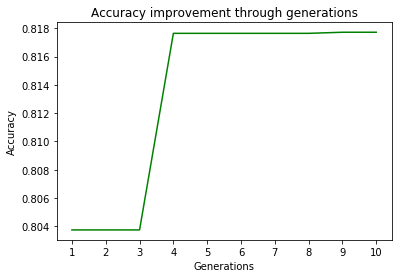

In [21]:
generations=[1,2,3,4,5,6,7,8,9,10]
plt.plot(generations,performances,color='g')
plt.xlabel('Generations')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Accuracy')
plt.title('Accuracy improvement through generations')
plt.show()

### Analisys of parameters select by GA

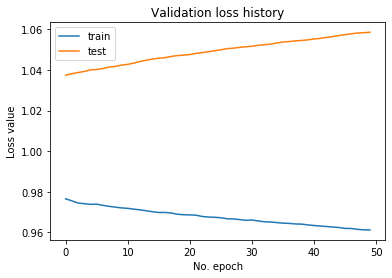

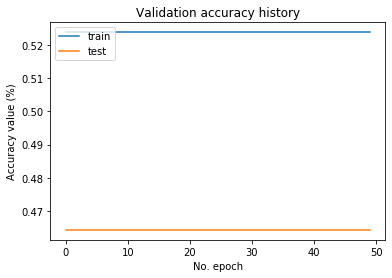

In [22]:
model = update_model_parameters(chromosome)

    
history = model.fit(X_test, y_test, validation_split=0.33, epochs=50, batch_size=64, verbose=0)


# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()    

In [23]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=0)      
accuracy, recall_0, precision_0, recall_1, precision_1 = evaluatePredictions(model, X_test, y_test)

predicted = model.predict(X_test)

y_pred = roundPredictions(predicted)

        
target_names = ['Benign', 'Malignant']
print(classification_report(y_test, y_pred, target_names=target_names))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: " +str(tp))
print("True Negatives: " +str(tn))
print("False Positives: " +str(fp))
print("False Negatives: " +str(fn))

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       125
   Malignant       0.50      1.00      0.67       127

    accuracy                           0.50       252
   macro avg       0.25      0.50      0.34       252
weighted avg       0.25      0.50      0.34       252

True Positives: 127
True Negatives: 0
False Positives: 125
False Negatives: 0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
